In [1]:
import os
import time
import random

import matplotlib.pyplot as plt
import timm
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import pandas as pd
import numpy as np
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm
from sklearn.metrics import accuracy_score, f1_score
from augraphy import AugraphyPipeline, Folding, InkBleed, Brightness, NoiseTexturize, PaperFactory

In [2]:
# # 시드를 고정합니다.
# SEED = 42
# os.environ['PYTHONHASHSEED'] = str(SEED)
# random.seed(SEED)
# np.random.seed(SEED)
# torch.manual_seed(SEED)
# torch.cuda.manual_seed(SEED)
# torch.cuda.manual_seed_all(SEED)
# torch.backends.cudnn.benchmark = True

In [3]:
!pip install seaborn

In [2]:
from PIL import Image
import os

train_path = "./../../data/train"
test_path = "./../../data/test"

train_list = os.listdir(train_path)
test_list = os.listdir(test_path)

print(len(train_list))
print(len(test_list))

# 이미지 패스에 있는 이미지들 가져오기
train_images = [Image.open(os.path.join(train_path, img)) for img in train_list]
test_images = [Image.open(os.path.join(test_path, img)) for img in test_list]

print(len(train_images))
print(len(test_images))

1570
3140
1570
3140


In [6]:
print(A.__version__)

2.0.8


# 랜덤으로 이미지 확인해보기

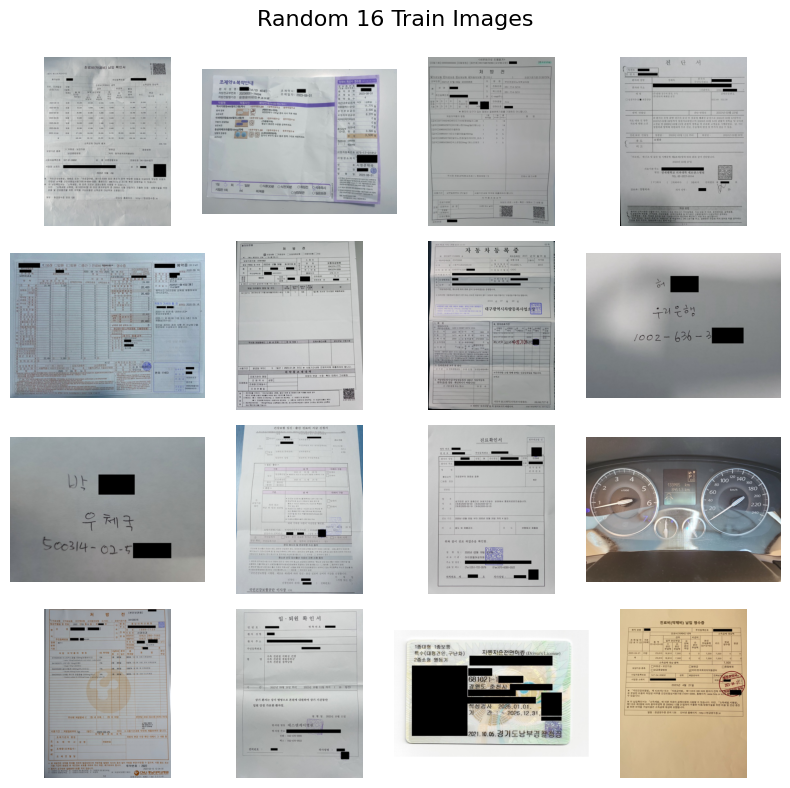

In [18]:
import random
import matplotlib.pyplot as plt

# 랜덤 16장 선택
sample_train_images = random.sample(train_images, 16)

def show_image_grid(images, title='Image Grid'):
    fig, axes = plt.subplots(4, 4, figsize=(8, 8))
    fig.suptitle(title, fontsize=16)
    
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.92)
    plt.show()

# 트레인 이미지 시각화
show_image_grid(sample_train_images, title='Random 16 Train Images')


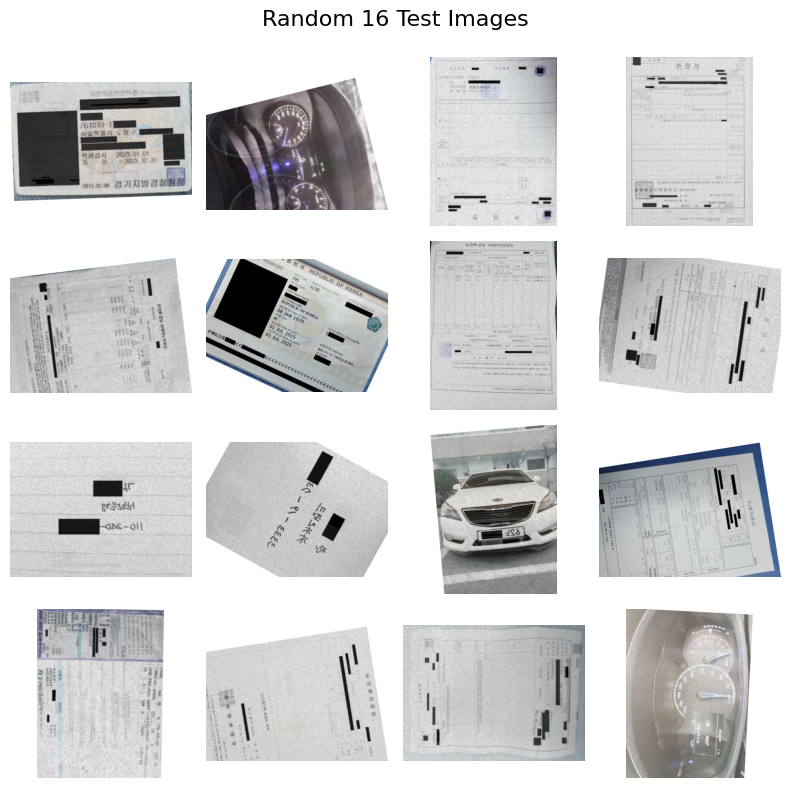

In [16]:
sample_test_images = random.sample(test_images, 16)
show_image_grid(sample_test_images, title='Random 16 Test Images')

In [40]:
aug_pipeline = AugraphyPipeline(
            ink_phase=[InkBleed(
                intensity_range=(0.5, 0.9),
                kernel_size=(5, 5),
                severity=(0.2, 0.4)
            ),
              # NoiseTexturize(
              #     sigma_range=(6, 9),
              #     turbulence_range=(2, 4),
              #     p=0.5
              # ),
            ],
            paper_phase=[
                
            ],
            post_phase=[
                Brightness(
                    brightness_range=(0.7, 1.3),
                    min_brightness=0,
                ),
            ]
        )

# transform_pipeline = transforms.Compose([
#     transforms.Lambda(lambda x: np.array(x)),
#     aug_pipeline,
#     transforms.Lambda(lambda x: Image.fromarray(x)),
#     transforms.RandomRotation(degrees=(-160, 160)),
#     transforms.ToTensor(),
# ])

transform_pipeline = A.Compose([
    A.Rotate(limit=160, p=0.8),
    A.RandomShadow(
      shadow_roi=(0, 0, 1, 1),
      num_shadows_limit=(1, 3), 
      shadow_dimension=6, 
      shadow_intensity_range=(0.2, 0.4),
      p=0.8),
    ToTensorV2()
])


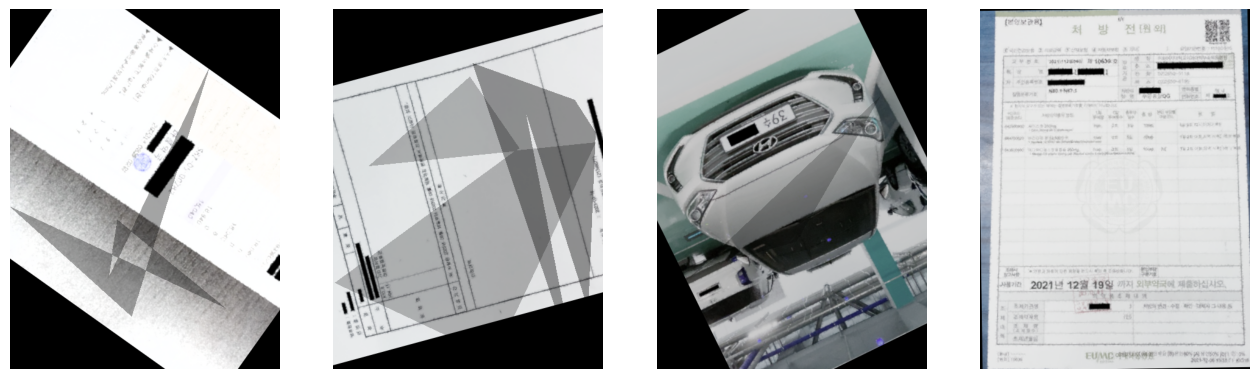

In [48]:
plt.figure(figsize=(16, 10))
for i in range(4):
    img = random.choice(train_images)
    img = np.array(img)
    img = aug_pipeline(img)
    img = transform_pipeline(image = img)
    img = img['image']
    img = img.permute(1, 2, 0).numpy()

    plt.subplot(1, 4, i + 1)
    plt.imshow(img)
    plt.axis('off')

plt.show()

# Data 크기 및 비율 확인

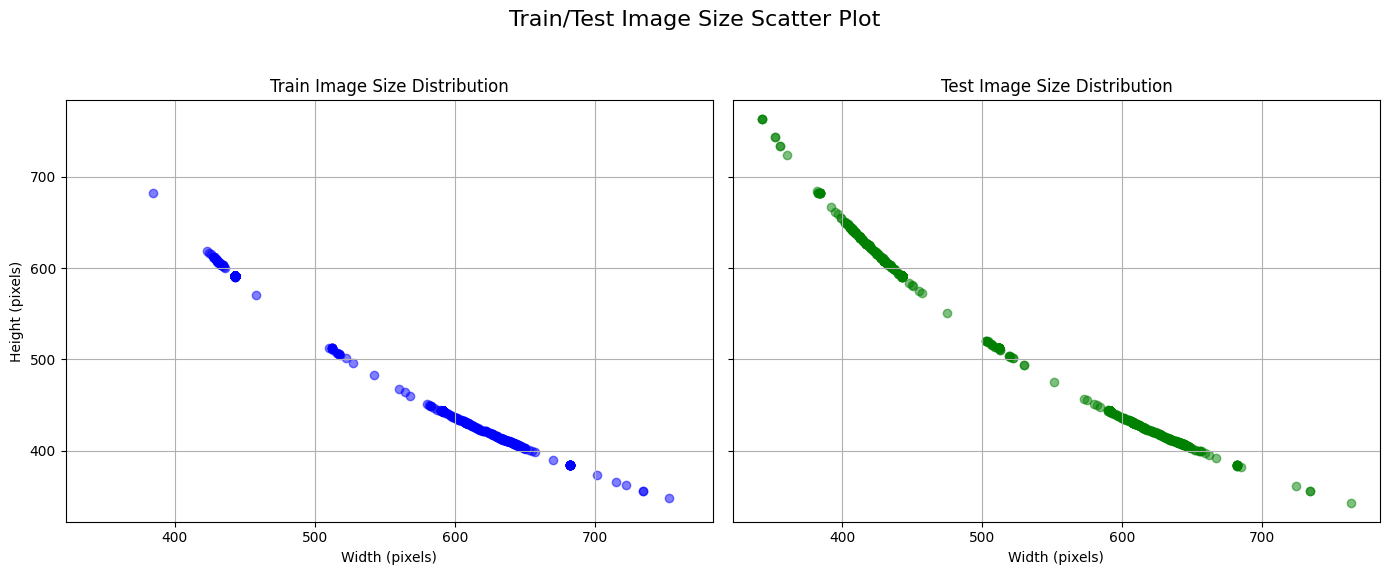

In [16]:
import matplotlib.pyplot as plt

train_image_sizes = [img.size for img in train_images]
test_image_sizes = [img.size for img in test_images]

# 너비와 높이 분리
train_widths = [w for w, h in train_image_sizes]
train_heights = [h for w, h in train_image_sizes]

test_widths = [w for w, h in test_image_sizes]
test_heights = [h for w, h in test_image_sizes]

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Train 이미지 분포
axes[0].scatter(train_widths, train_heights, c='blue', alpha=0.5)
axes[0].set_title('Train Image Size Distribution')
axes[0].set_xlabel('Width (pixels)')
axes[0].set_ylabel('Height (pixels)')
axes[0].grid(True)

# Test 이미지 분포
axes[1].scatter(test_widths, test_heights, c='green', alpha=0.5)
axes[1].set_title('Test Image Size Distribution')
axes[1].set_xlabel('Width (pixels)')
axes[1].grid(True)

plt.suptitle('Train/Test Image Size Scatter Plot', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


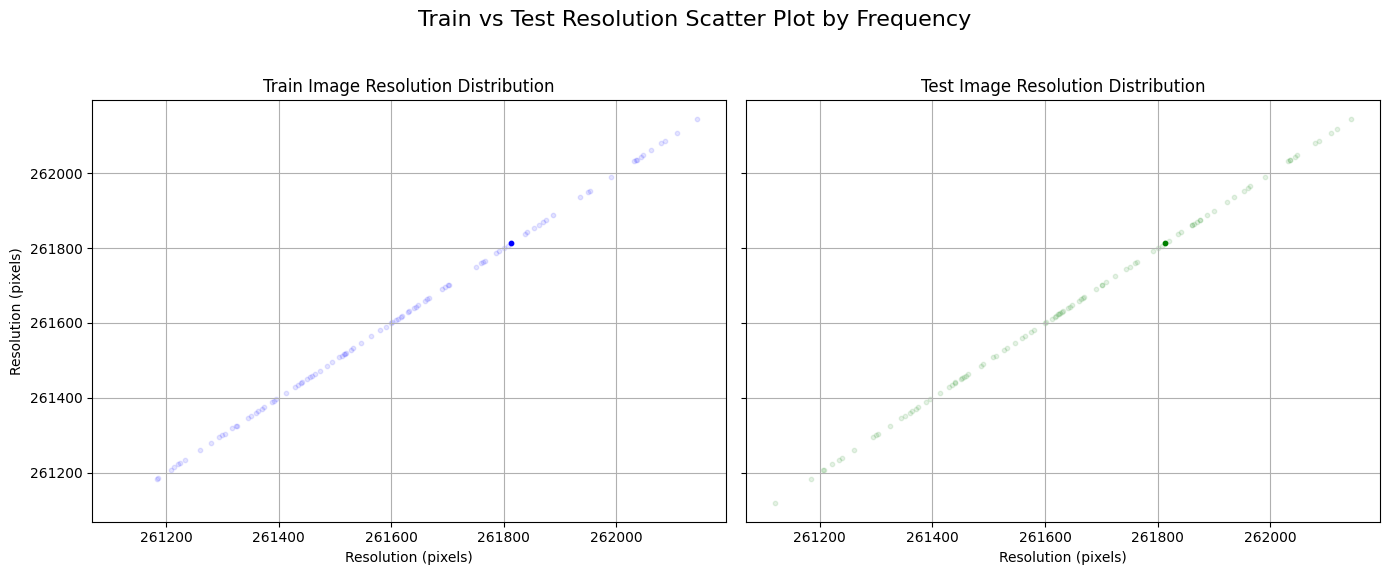

In [17]:
import matplotlib.pyplot as plt
from collections import Counter

# 해상도 계산
train_resolutions = [w * h for w, h in train_image_sizes]
test_resolutions = [w * h for w, h in test_image_sizes]

# 해상도별 빈도수 계산
train_counts = Counter(train_resolutions)
test_counts = Counter(test_resolutions)

# 최대 빈도 (정규화용)
max_train_count = max(train_counts.values())
max_test_count = max(test_counts.values())

# subplot 그리기
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)

# Train subplot
for res in train_counts:
    alpha = min(0.1 + train_counts[res] / max_train_count, 1.0)
    axes[0].scatter(res, res, c='blue', alpha=alpha, s=10)
axes[0].set_title('Train Image Resolution Distribution')
axes[0].set_xlabel('Resolution (pixels)')
axes[0].set_ylabel('Resolution (pixels)')
axes[0].grid(True)

# Test subplot
for res in test_counts:
    alpha = min(0.1 + test_counts[res] / max_test_count, 1.0)
    axes[1].scatter(res, res, c='green', alpha=alpha, s=10)
axes[1].set_title('Test Image Resolution Distribution')
axes[1].set_xlabel('Resolution (pixels)')
axes[1].grid(True)

plt.suptitle('Train vs Test Resolution Scatter Plot by Frequency', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [19]:
import pandas as pd

train_image_sizes_df = pd.Series(train_image_sizes)
test_image_sizes_df = pd.Series(test_image_sizes)

print(train_image_sizes_df.value_counts())
print(test_image_sizes_df.value_counts())


(443, 591)    1004
(591, 443)     282
(682, 384)      18
(608, 430)      10
(643, 407)       8
              ... 
(580, 451)       1
(581, 450)       1
(650, 402)       1
(606, 431)       1
(384, 682)       1
Name: count, Length: 125, dtype: int64
(443, 591)    1342
(591, 443)    1270
(512, 512)      22
(430, 608)      20
(608, 430)      12
              ... 
(450, 582)       1
(551, 475)       1
(763, 343)       1
(631, 415)       1
(395, 662)       1
Name: count, Length: 193, dtype: int64


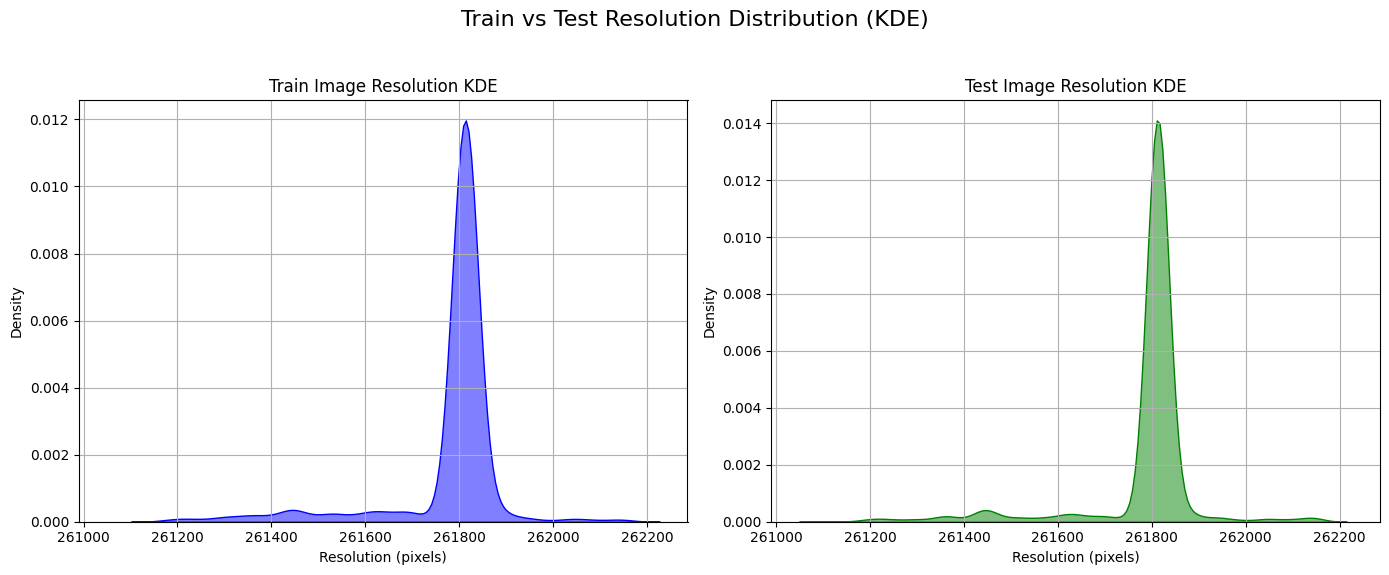

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# 해상도 계산 (이미 있음)
# train_resolutions = [w * h for w, h in train_image_sizes]
# test_resolutions = [w * h for w, h in test_image_sizes]

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# Train KDE
sns.kdeplot(train_resolutions, ax=axes[0], fill=True, color='blue', alpha=0.5)
axes[0].set_title('Train Image Resolution KDE')
axes[0].set_xlabel('Resolution (pixels)')
axes[0].set_ylabel('Density')
axes[0].grid(True)

# Test KDE
sns.kdeplot(test_resolutions, ax=axes[1], fill=True, color='green', alpha=0.5)
axes[1].set_title('Test Image Resolution KDE')
axes[1].set_xlabel('Resolution (pixels)')
axes[1].set_ylabel('Density')
axes[1].grid(True)

plt.suptitle('Train vs Test Resolution Distribution (KDE)', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


# 클래스 분포 확인

In [20]:
meta_path = "./../../data/train.csv"

train_df = pd.read_csv(meta_path)

train_df_target = train_df.groupby("target").count()
print(train_df_target)

         ID
target     
0       100
1        46
2       100
3       100
4       100
5       100
6       100
7       100
8       100
9       100
10      100
11      100
12      100
13       74
14       50
15      100
16      100
